# Problem 2

## Problem Description

Several molecular dynamics simulations have been carried out for a material, and the phase (solid/liquid/vapor) at different temperature/pressure combinations has been recorded.

You will use gradient descent to train a One-vs-Rest logistic regression model on data with 3 classes. Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the previous problems.*

#### Summary of deliverables:
- 3 binomial classification `w` vectors, corresponding to each class
- Function `classify(xy)` that evaluates all 3 models at a given array of points, returning the class prediction as the model with the highest probability
- Print model percent classification accuracy on the training data
- Print model percent classification accuracy on the testing data
- Plot that shows the training data as data points, along with the class of a grid of points in the background, as in the lecture activity.

### Imports and Utility Functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import PolynomialFeatures

def plot_data(x, y, c,title="Phase of simulated material"):
    xlim = [0,52.5]
    ylim = [0,1.05]
    markers = [dict(marker="o", color="royalblue"), dict(marker="s", color="crimson"), dict(marker="^", color="limegreen")]
    labels = ["Solid", "Liquid", "Vapor"]

    plt.figure(dpi=150)

    for i in range(1+max(c)):
        plt.scatter(x[c==i], y[c==i], s=60, **(markers[i]), edgecolor="black", linewidths=0.4,label=labels[i])

    plt.title(title)
    plt.legend(loc="upper right")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Temperature, K")
    plt.ylabel("Pressure, atm")
    plt.box(True)

def plot_colors(classify, res=40):
    xlim = [0,52.5]
    ylim = [0,1.05]
    xvals = np.linspace(*xlim,res)
    yvals = np.linspace(*ylim,res)
    x,y = np.meshgrid(xvals,yvals)
    XY = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)

    color = classify(XY).reshape(res,res)

    cmap = ListedColormap(["lightblue","lightcoral","palegreen"])
    plt.pcolor(x, y, color, shading="nearest", zorder=-1, cmap=cmap,vmin=0,vmax=2)
    return

## Load Data
This cell loads the dataset into the following variables:
- `train_data`: Nx2 array of input features, used for training
- `train_gt`: Array of ground-truth classes for each point in `train_data`
- `test_data`: Nx2 array of input features, used for testing
- `test_gt`: Array of ground-truth classes for each point in `test_data`

In the class arrays, 0 = solid, 1 = liquid, 2 = vapor.

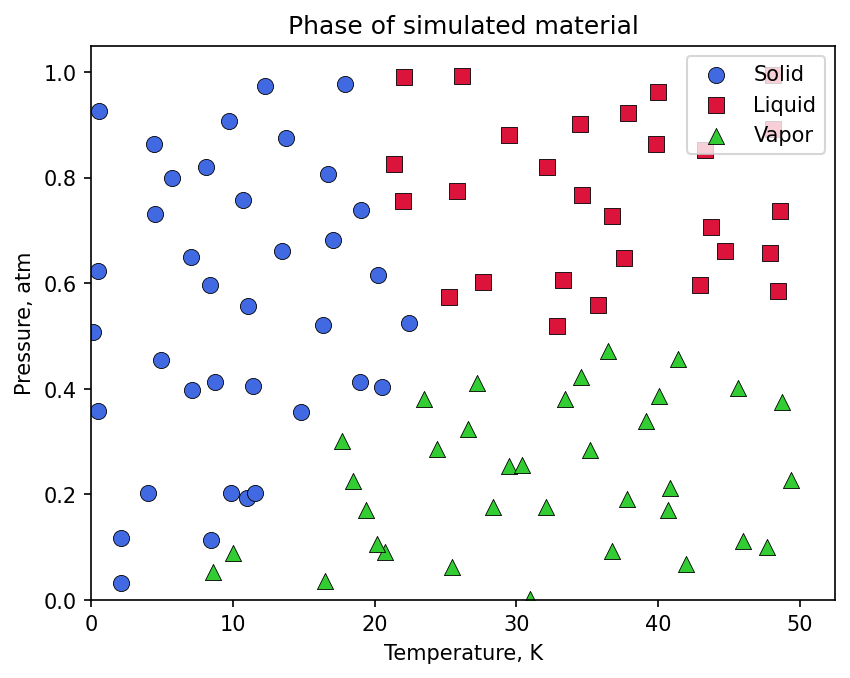

In [2]:
train = np.load("data/w3-hw2-data-train.npy")
test = np.load("data/w3-hw2-data-test.npy")
train_data, train_gt = train[:,:2], train[:,2].astype(int)
test_data, test_gt = test[:,:2], test[:,2].astype(int)
plot_data(train_data[:,0], train_data[:,1],train_gt)

## Gradient Descent

Here, write all of the necessary code to perform gradient descent and train 3 logistic regression models for a 1-vs-rest scenario. Use linear decision boundaries (features should only be 1, temperature, pressure)


Feel free to reuse code from the first problem or lecture activities.

We have provided the following function to help with the one-vs-all method:  

`convert_to_binary_dataset(classes, A)`:
- Input: data, Nx2 array of temperature-pressure data
- Input: classes, array (size N) of class values for each point in `data`
- Input: A, the class (0, 1, or 2 here) to use as '1' in the binary dataset
- Returns: `classes_binary`, copy of classes where class A is 1, and all other classes are 0.



In [3]:
def convert_to_binary_dataset(classes, A):
    return (classes == A).astype(int)

In [4]:
def sigmoid(h):
   return 1 / (1 + np.exp(-h))

def map_features(data):
    ones = np.ones((data.shape[0], 1))
    return np.hstack([ones, data])

def grad_desc(data, y, w0, iterations=10000, stepsize=0.01):
    w = w0.copy()
    X = map_features(data)
    m = len(y)
    losses = []

    for i in range(iterations):
        h = X @ w
        p = sigmoid(h)
        error = p - y
        gradient = (X.T @ error) / m
        w = w - stepsize * gradient

    return w

# Training
Train your 3 models and print the `w` vector corresponding to each class

In [37]:
temp_features = map_features(train_data)
num_features = temp_features.shape[1]
num_classes = len(np.unique(train_gt))

all_weights = []

for cl in range(num_classes):
    y_binary = convert_to_binary_dataset(train_gt, cl)
    initial_weights = np.zeros(num_features)
    w_optimal = grad_desc(train_data, y_binary, initial_weights, iterations=40000, stepsize=0.02)
    all_weights.append(w_optimal)
    print(f"Class {cl} Weights: {w_optimal}")

w = np.array(all_weights).T

Class 0 Weights: [ 5.02174317 -0.40451047  4.74386109]
Class 1 Weights: [-11.24064654   0.16591641   9.41268039]
Class 2 Weights: [  0.26277694   0.17874451 -13.96508043]


## Classification function
Write a function `classify(xy)` that will evaluate each model and select the appropriate class.


In [38]:
def classify(xy):
    X = map_features(xy)
    probabilities = sigmoid(X @ w)
    predictions = np.argmax(probabilities, axis=1)
    return predictions

## Accuracy
Compute and print the accuracy on the training and testing sets as a percent

In [40]:
def get_accuracy(data, classes, classifier_func):
    predictions = classifier_func(data)
    accuracy = np.sum(predictions == classes) / len(classes) * 100
    return accuracy

train_acc = get_accuracy(train_data, train_gt, classify)
test_acc = get_accuracy(test_data, test_gt, classify)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Testing Accuracy:  {test_acc:.2f}%")

Training Accuracy: 95.00%
Testing Accuracy:  96.00%


## Plot results
Run this cell to visualize the data along with the results of `classify()`

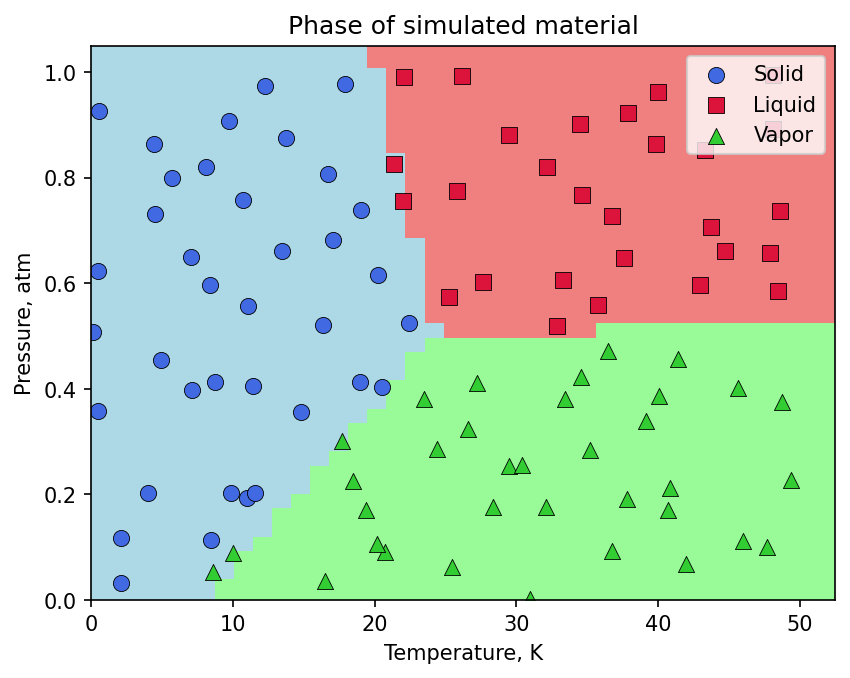

In [41]:
plot_data(train_data[:,0], train_data[:,1], train_gt)
plot_colors(classify)